https://www.cell.com/cms/10.1016/j.cell.2011.10.047/attachment/117b6d14-799a-4f63-ac31-d40a323ddefa/mmc1.pdf


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [169]:
S_A = np.loadtxt('S_A_100hr_sim_final.csv', delimiter = ',')
S_B = np.loadtxt('S_B_100hr_sim_final.csv', delimiter = ',')
print(S_A.shape, S_B.shape)
dS_A = np.loadtxt('delta_S_A_100hr_sim_final.csv', delimiter = ',')
dS_B = np.loadtxt('delta_S_B_100hr_sim_final.csv', delimiter = ',')
print(dS_A.shape, dS_B.shape)

(6000, 420) (6003, 420)
(6000, 420) (6000, 420)


In [170]:
S = np.concatenate((S_A, S_B), axis = 0)
dS = np.concatenate((dS_A, dS_B), axis = 0)
print(S.shape)

(12003, 420)


In [171]:
def norm_S(S):
    normed_S = S.copy()
    normed_S -= np.min(normed_S)
    return normed_S

In [172]:
normalized_S = np.zeros(S.shape)

for i in range(len(S)):
    normed_S = norm_S(S[i])
    normalized_S[i] = normed_S 

In [268]:
conversion = 5/np.max(normalized_S)
print(conversion)

15465.039663558979


In [288]:
# parameters:
alpha = 3 # Pmax
beta = 5 # Omax
gamma = 5 # Nmax
h1 = 6 # N repression of P strength
h2 = 2 # O repression of P strength
h3 = 5 # N repression of O strength
h4 = 1 # O rep of N str
h5 = 1 # P rep of N str
k1 = 1 # P degradation
k2 = 1 # O deg
k3 = 1 # N deg

# XcritY is the critical value of X for which y is half maximal
OcritP = 1
NcritP = 1
OcritN = 1
NcritO = 1
PcritN = 1
n = 1 # Hill coef of G on O
m = 1 # Hill coef of G on N

P0 = 3 # starting value for P
O0 = 0 # starting value for O
N0 = 0 # starting value for N

In [289]:
# ODEs:

def dP(N,O,P,i):
    G = normalized_S[i] * conversion
    Nfrac = (N/NcritP)**h1
    Ofrac = (O/OcritP)**h2
    denom = 1 + Nfrac + Ofrac
    frac = alpha/denom
    return(frac-k1*P)

def dO(N,O,P,i):
    G = normalized_S[i] * conversion
    Gterm = (beta*G)/(1+G)
    Nfrac = (N/NcritO)**h3
    frac = 1/(1+Nfrac)
    return(Gterm*frac-k2*O)

def dN(N,O,P,i):
    G = normalized_S[i] * conversion
    Gterm = (gamma*G)/(1+G)
    Ofrac = (O/OcritN)**h4
    Pfrac = (P/PcritN)**h5
    frac = 1/(1+Ofrac+Pfrac)
    return(Gterm*frac - k3*N)

In [290]:
# PLOTTING through t with G fixed

t = 23
h = 0.002
n = int(t/h)

N = N0*np.zeros(420)
O = O0*np.zeros(420)
P = P0*np.zeros(420)
#G = 5 # level used in Briscoe Paper

ts = np.linspace(0,t,n)
Ns = np.zeros((n, 420))
Os = np.zeros((n, 420))
Ps = np.zeros((n, 420))
Ns[0] = N
Os[0] = O
Ps[0] = P
for i in range(1,n):
    N = N + h*dN(N,O,P,i)
    O = O + h*dO(N,O,P,i)
    P = P + h*dP(N,O,P,i)  
    Ns[i] = N
    Os[i] = O
    Ps[i] = P

In [291]:
Ns.shape

(11500, 420)

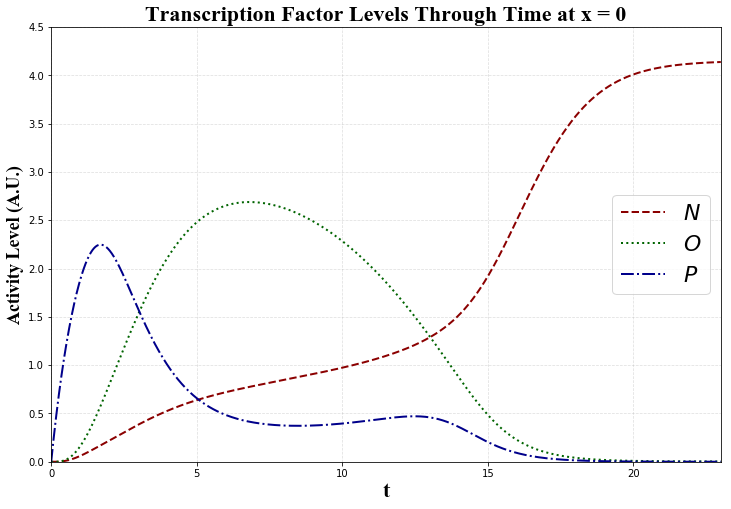

In [292]:
i = 0

plt.figure(figsize=(12,8))
myfont = {'fontname':'Times New Roman'}
plt.title('Transcription Factor Levels Through Time at x = {0}'.format(i),**myfont, fontsize = 22)
plt.plot(ts,Ns[:, i], label="$N$", color ='darkred', linestyle='--', linewidth=2)
plt.plot(ts,Os[:, i], label="$O$", color ='darkgreen', linestyle=':', linewidth=2)
plt.plot(ts,Ps[:, i], label="$P$", color ='darkblue', linestyle="-.", linewidth=2)
#plt.fill_between(ts,Ns,0, alpha = 0.15, color='red')
#plt.fill_between(ts,Os,0, alpha = 0.15, color='green')
#plt.fill_between(ts,Ps,0, alpha = 0.15, color='blue')
plt.legend(loc='center right', fontsize=22)
plt.margins(x=0, y=0)
plt.xlabel("t",**myfont, fontsize=22)
plt.ylabel("Activity Level (A.U.)",**myfont, fontsize=18)
plt.ylim((0,4.5))
plt.grid(True, lw=.75, ls='--', alpha=0.4)
plt.show()
# plt.savefig("model2_activity_time")

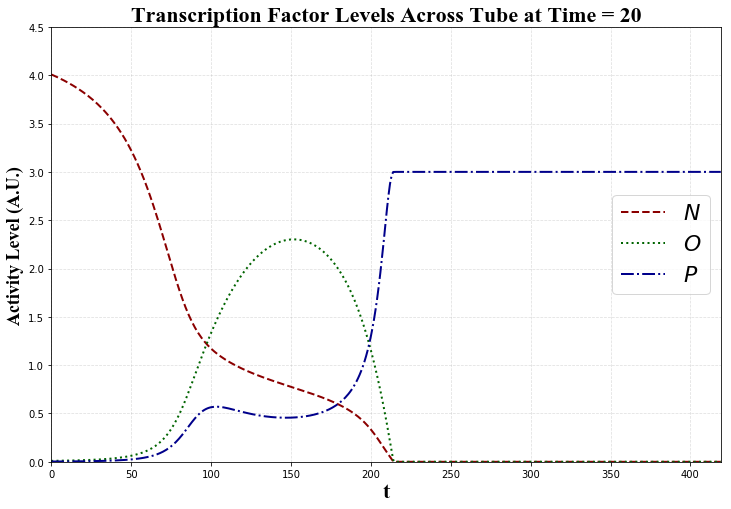

In [293]:
plt.figure(figsize=(12,8))
myfont = {'fontname':'Times New Roman'}
plt.title('Transcription Factor Levels Across Tube at Time = 20',**myfont, fontsize = 22)
plt.plot(Ns[10000], label="$N$", color ='darkred', linestyle='--', linewidth=2)
plt.plot(Os[10000], label="$O$", color ='darkgreen', linestyle=':', linewidth=2)
plt.plot(Ps[10000], label="$P$", color ='darkblue', linestyle="-.", linewidth=2)
#plt.fill_between(ts,Ns,0, alpha = 0.15, color='red')
#plt.fill_between(ts,Os,0, alpha = 0.15, color='green')
#plt.fill_between(ts,Ps,0, alpha = 0.15, color='blue')
plt.legend(loc='center right', fontsize=22)
plt.margins(x=0, y=0)
plt.xlabel("t",**myfont, fontsize=22)
plt.ylabel("Activity Level (A.U.)",**myfont, fontsize=18)
plt.ylim((0,4.5))
plt.grid(True, lw=.75, ls='--', alpha=0.4)
plt.show()
# plt.savefig("model2_activity_time")

In [275]:
# PLOTTING through G with t fixed
gn = 100

Gs = np.linspace(0,5,gn)
Ns = np.zeros(gn)
Os = np.zeros(gn)
Ps = np.zeros(gn)

for i, G in enumerate(Gs):
    t = 20
    h = 0.01
    n = int(t/h)
    N = N0
    O = O0
    P = P0
    for j in range(1,n):
        N = N + h*dN(N,O,P,G)
        O = O + h*dO(N,O,P,G)
        P = P + h*dP(N,O,P,G) 
    Ns[i] = N
    Os[i] = O
    Ps[i] = P
    

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

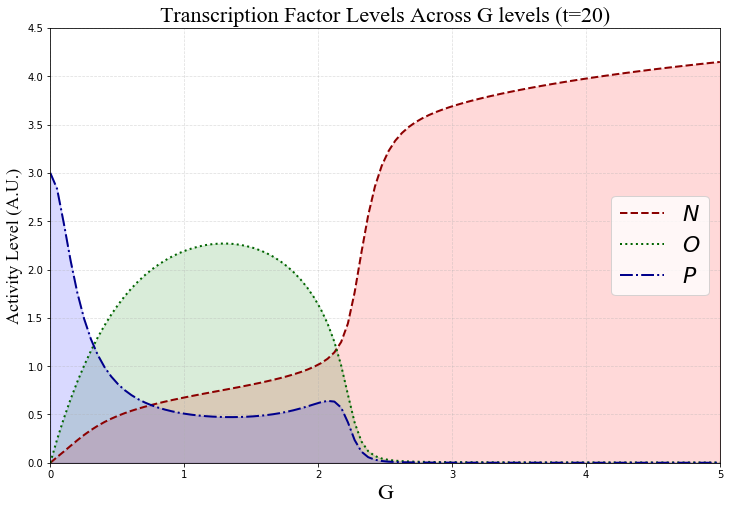

In [26]:
plt.figure(figsize=(12,8))
myfont = {'fontname':'Times New Roman'}
plt.title('Transcription Factor Levels Across G levels (t=20)',**myfont, fontsize = 22)
plt.plot(Gs,Ns, label="$N$", color ='darkred', linestyle='--', linewidth=2)
plt.plot(Gs,Os, label="$O$", color ='darkgreen', linestyle=':', linewidth=2)
plt.plot(Gs,Ps, label="$P$", color ='darkblue', linestyle="-.", linewidth=2)
plt.fill_between(Gs,Ns,0, alpha = 0.15, color='red')
plt.fill_between(Gs,Os,0, alpha = 0.15, color='green')
plt.fill_between(Gs,Ps,0, alpha = 0.15, color='blue')
plt.legend(loc='center right', fontsize=22)
plt.margins(x=0, y=0)
plt.xlabel("G",**myfont, fontsize=22)
plt.ylabel("Activity Level (A.U.)",**myfont, fontsize=18)
plt.ylim((0,4.5))
plt.grid(True, lw=.75, ls='--', alpha=0.4)
plt.show()
# plt.savefig("model2_activity_Ginput")